In [1]:
# | tags: [parameters]
subject = "101"

In [2]:
#| tags: [parameters]
# Injected Parameters
subject = 151


In [3]:
import os
import mne
from pathlib import Path
import autoreject
from autoreject import AutoReject
import numpy as np
import matplotlib.pyplot as plt

from spectral.utils import print_date_time, read_parameters, config_project
from spectral.epochs import create_epochs, get_reject_log
from spectral.viz import plot_epochs

mne.viz.set_browser_backend("matplotlib")
# mne.viz.set_browser_backend("qt")
mne.set_config("MNE_BROWSER_THEME", "light")
# matplotlib.use("Agg")

config = read_parameters()
my_paths = config_project(subject)

project_path = my_paths["project_path"]
raw_preproc_path = my_paths["raw_preproc_path"]
epochs_preproc_path = my_paths["epochs_preproc_path"]

print(epochs_preproc_path)
Path(epochs_preproc_path).mkdir(parents=True, exist_ok=True)

figures_path = my_paths["figures_path"]

print_date_time()

Using matplotlib as 2D backend.


/Users/daniel/PhD/Projects/psd-path/analysis/data/epochs/sub-151/
2024-03-29 13:25:03


# Get bad channels


Opening raw data file /Users/daniel/PhD/Projects/psd-path/analysis/data/raw/sub-151//sub-151_filtered_zap_eeg.fif...


    Range : 1000 ... 150000 =      2.000 ...   300.000 secs


Ready.


Reading 0 ... 149000  =      0.000 ...   298.000 secs...


<Info | 11 non-empty values
 bads: 1 items (VREF)
 ch_names: E1, E2, E3, E4, E5, E6, E7, E8, E9, E10, E11, E12, E13, E14, ...
 chs: 257 EEG, 1 ECG
 custom_ref_applied: False
 dig: 260 items (3 Cardinal, 257 EEG)
 file_id: 4 items (dict)
 highpass: 1.0 Hz
 lowpass: 100.0 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 258
 projs: []
 sfreq: 500.0 Hz
>

Not setting metadata


84 matching events found


No baseline correction applied


0 projection items activated


Using data from preloaded Raw for 84 events and 2501 original time points ...


21 bad epochs dropped


No projector specified for this dataset. Please consider the method self.add_proj.


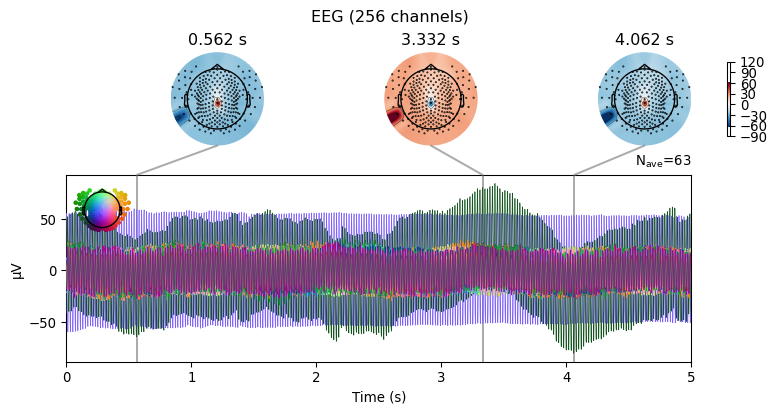

Effective window size : 4.096 (s)


Averaging across epochs...


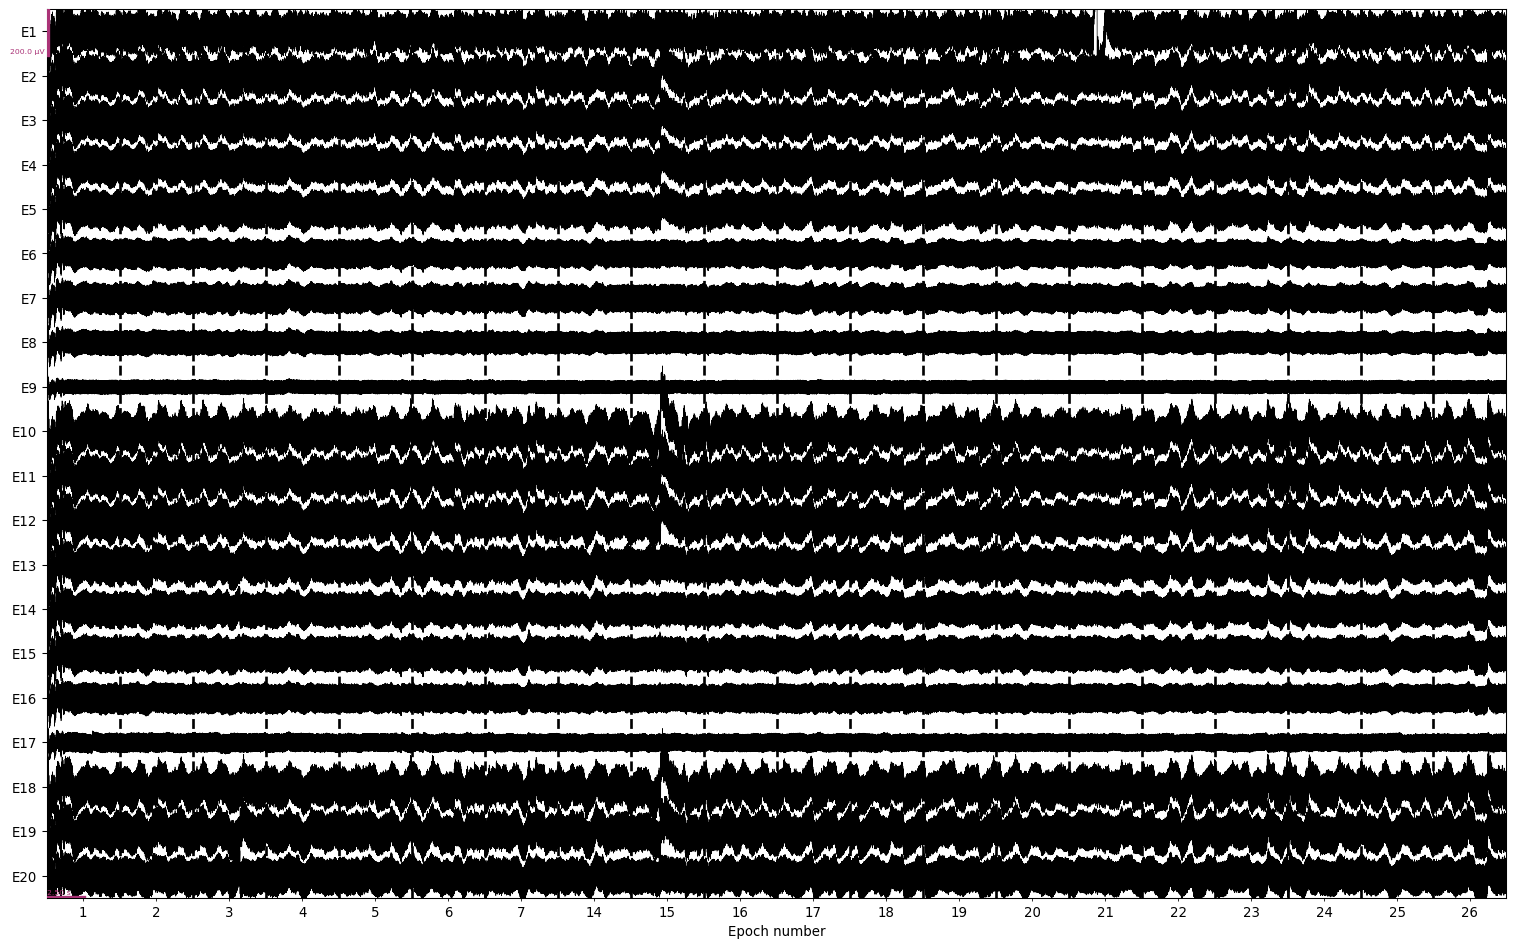

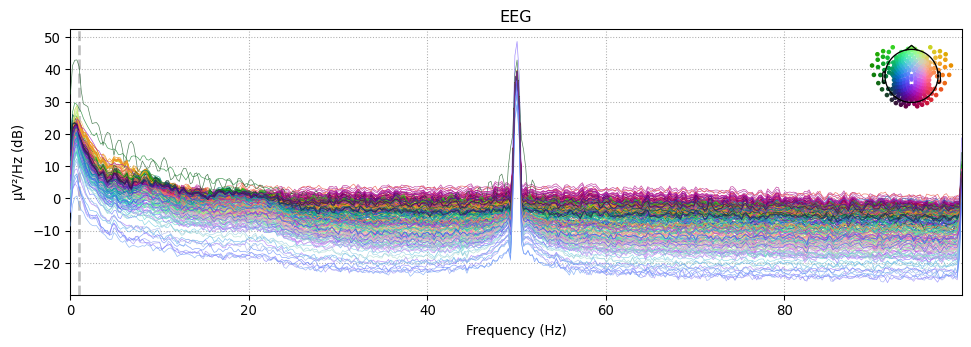

In [4]:
clean_raw = mne.io.read_raw_fif(
    f"{raw_preproc_path}/sub-{subject}_filtered_zap_eeg.fif", preload=True
)
display(clean_raw.info)
# clean_raw_downsampled = clean_raw.copy().resample(250, npad="auto")
epochs = create_epochs(clean_raw, overlap=1.5)
plot_epochs(
    epochs,
    figures_path=figures_path,
    subject=subject,
    stage="epochs",
    n_epochs=20,
    n_channels=20,
)

fitting finished


Dropped 5 epochs: 0, 1, 5, 20, 27


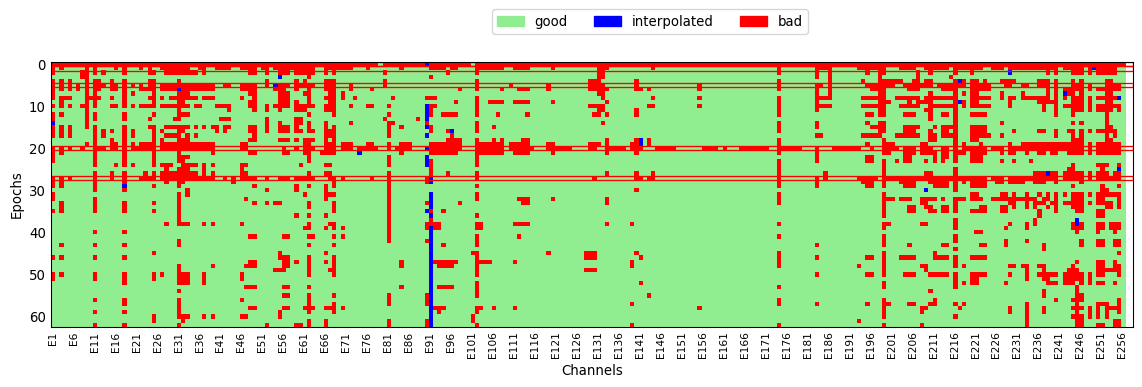

In [5]:
# depending of the resampling - different number of epochs are rejected
reject_log = get_reject_log(
    epochs, resample=125, n_interpolate=[1], consensus=[0.4])
reject_plot = reject_log.plot("vertical")

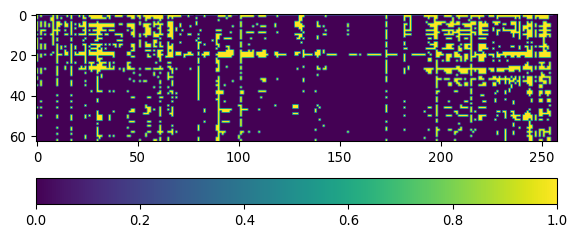

Currently removed number of epochs 5
Percentage of bad epochs in each candidate for removal epoch:
Epoch 0: 98.45%
Epoch 1: 48.06%
Epoch 5: 40.31%
Epoch 6: 34.88%
Epoch 8: 36.43%
Epoch 10: 39.15%
Epoch 19: 39.53%
Epoch 20: 65.50%
Epoch 21: 30.62%
Epoch 27: 43.02%


In [6]:
bads = np.logical_or(reject_log.labels == 1, reject_log.labels == 2)
plt.imshow(bads, cmap="viridis")
plt.colorbar(orientation="horizontal", pad=0.1)
plt.show()
print(f"Currently removed number of epochs {np.sum(reject_log.bad_epochs)}")
bad_epochs_percentage = bads.mean(axis=1) * 100
print("Percentage of bad epochs in each candidate for removal epoch:")
for i in range(0, len(bad_epochs_percentage)):
    if bad_epochs_percentage[i] > 25:
        print(f"Epoch {i}: {bad_epochs_percentage[i]:.2f}%")

Additinal 29 bad channels found:['E1', 'E11', 'E18', 'E25', 'E31', 'E32', 'E33', 'E62', 'E66', 'E68', 'E81', 'E91', 'E102', 'E174', 'E199', 'E210', 'E216', 'E220', 'E221', 'E237', 'E240', 'E244', 'E245', 'E246', 'E250', 'E251', 'E252', 'E254', 'E255']
No projector specified for this dataset. Please consider the method self.add_proj.


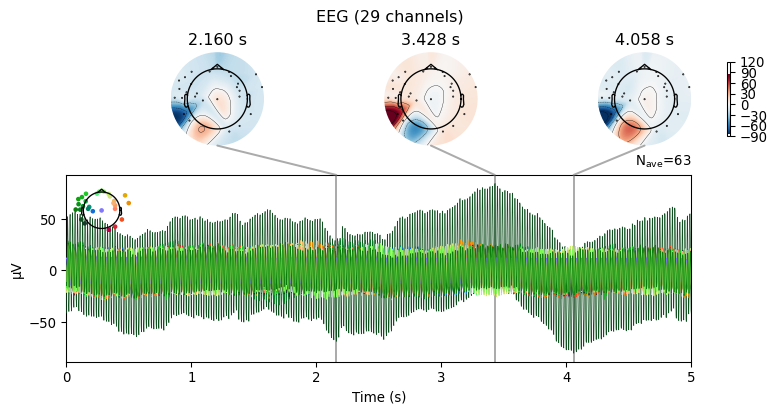

Effective window size : 4.096 (s)


Averaging across epochs...


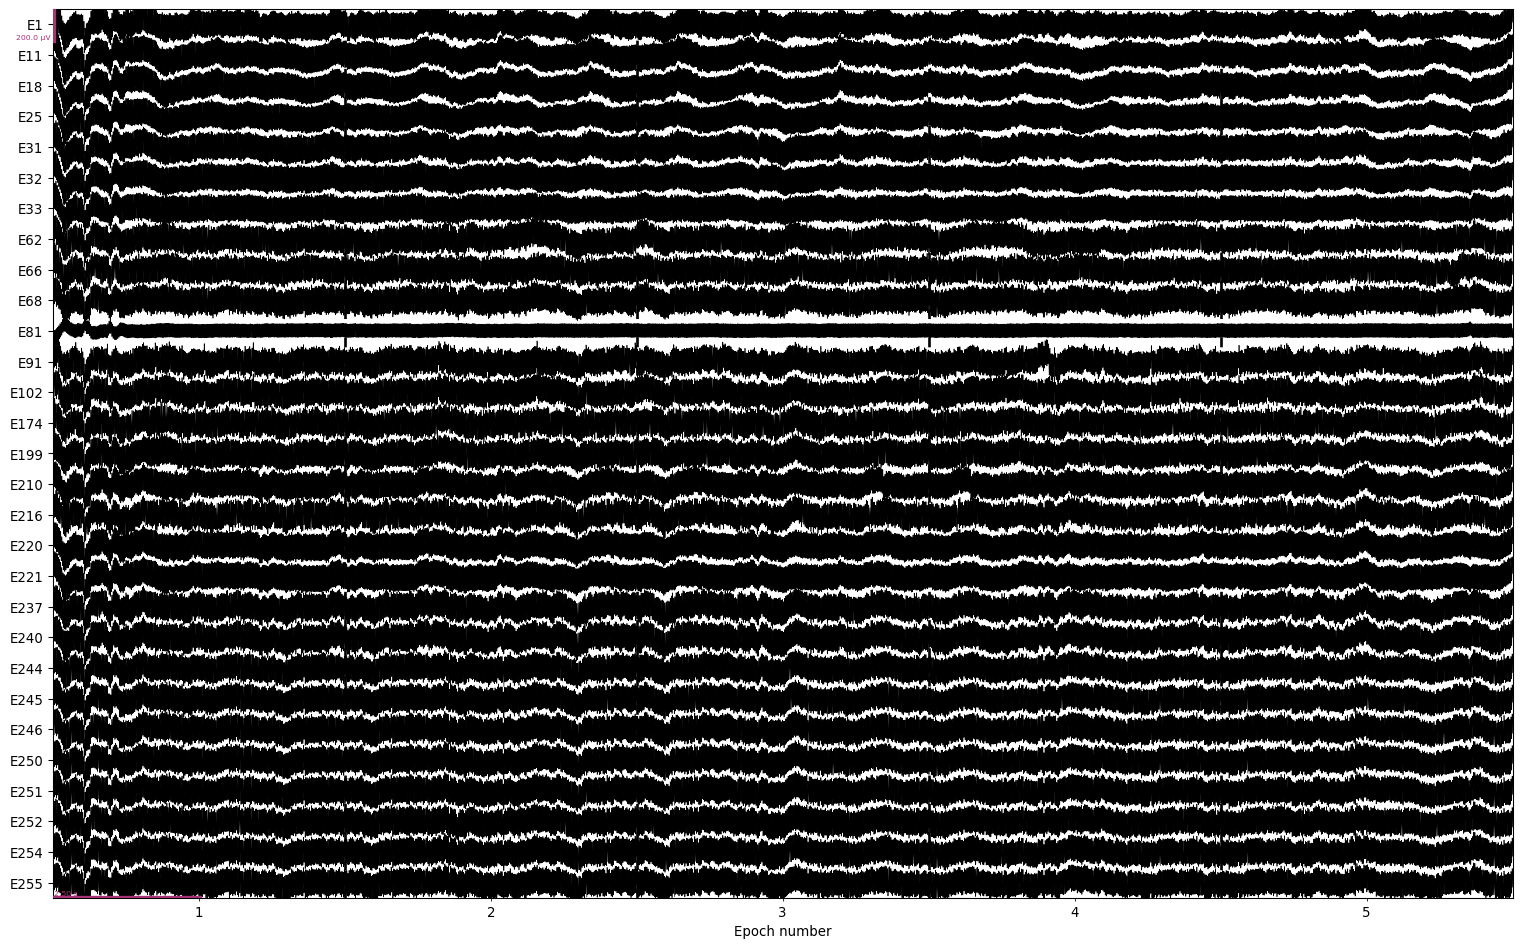

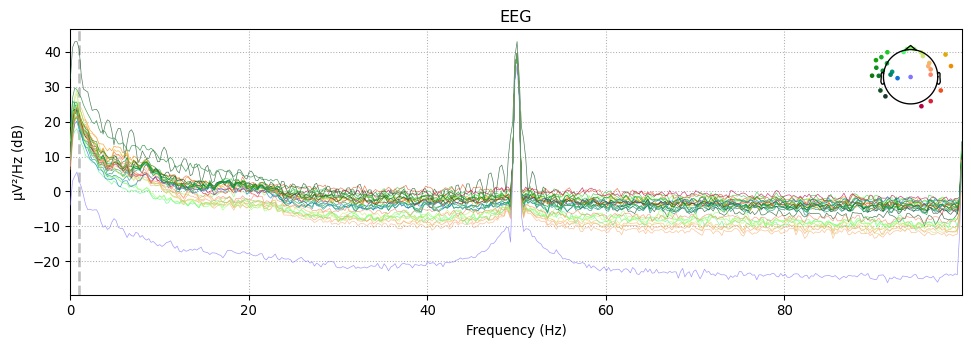

In [7]:
# Drop channels with more than 30% bad epochs
BADS_THRESHOLD = 0.4
bad_channel = bads.mean(axis=0)
# print(bad_channel)
epochs.info
channel_names = epochs.info["ch_names"]
bad_channels_by_epochs = [
    name for name, value in zip(channel_names, bad_channel) if value > BADS_THRESHOLD
]
# epochs.info['bads'].extend(new_bad_channels)
epochs_remove = epochs.copy().drop_channels(bad_channels_by_epochs)
print(
    f"Additinal {len(bad_channels_by_epochs)} bad channels found:{
        bad_channels_by_epochs}"
)
bad_channels_epochs = epochs.copy().pick(bad_channels_by_epochs)
epochs.info["bads"].extend(bad_channels_by_epochs)

try:
    if bad_channels_by_epochs:
        plot_epochs(
            bad_channels_epochs,
            figures_path=figures_path,
            subject=subject,
            stage="bad channels by number of rejected epochs",
            n_epochs=len(epochs[reject_log.bad_epochs]),
            n_channels=40,
        )
except Exception as e:
    print(f"Error: {e}")

## Show bad epochs


No projector specified for this dataset. Please consider the method self.add_proj.


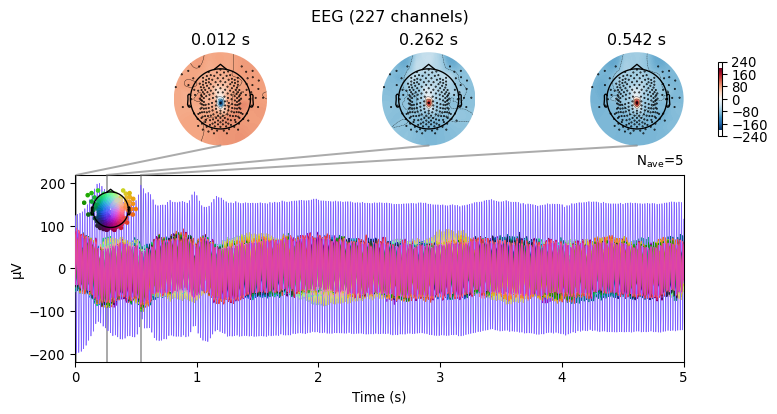

Effective window size : 4.096 (s)


Averaging across epochs...


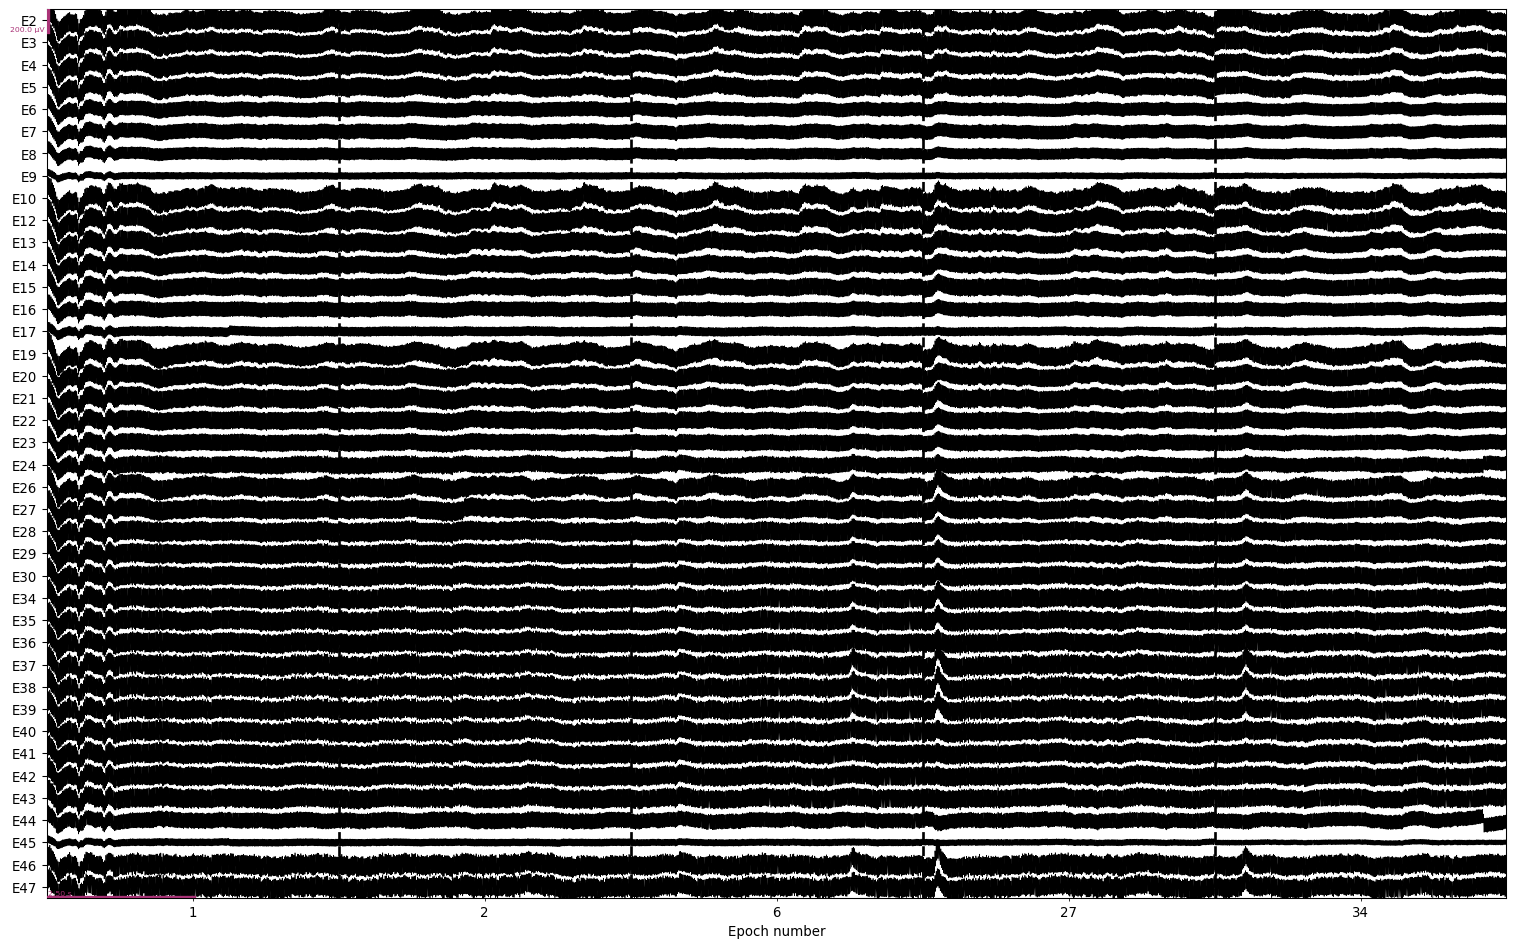

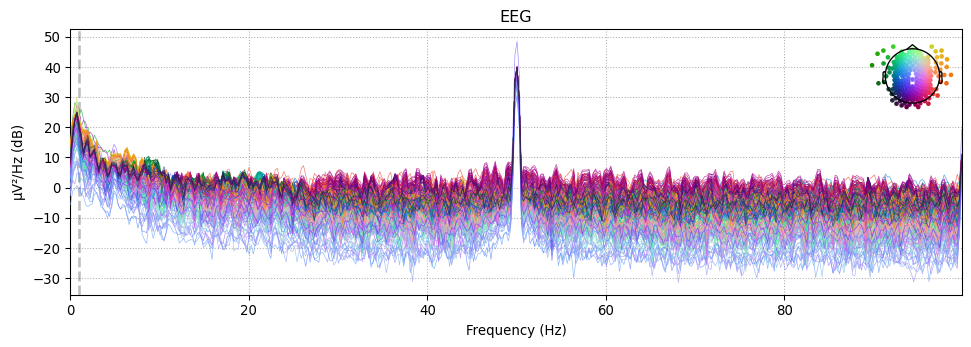

In [8]:
if sum(reject_log.bad_epochs):
    plot_epochs(
        epochs[reject_log.bad_epochs],
        figures_path=figures_path,
        subject=subject,
        stage="autoreject_bad_epochs",
        n_epochs=len(epochs[reject_log.bad_epochs]),
        n_channels=40,
    )

# Show good epochs after removal


No projector specified for this dataset. Please consider the method self.add_proj.


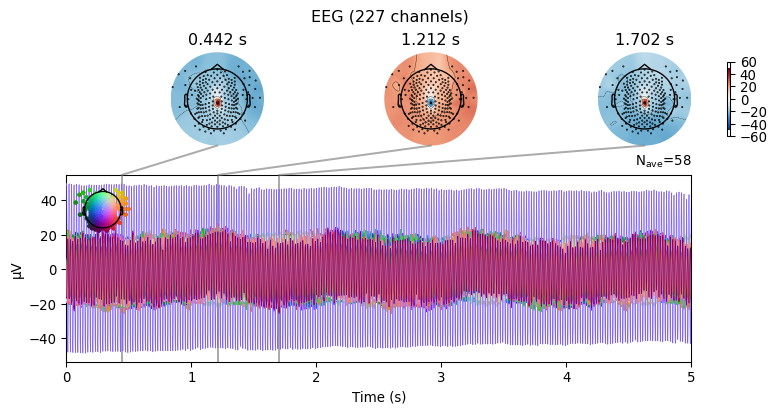

Effective window size : 4.096 (s)


Averaging across epochs...


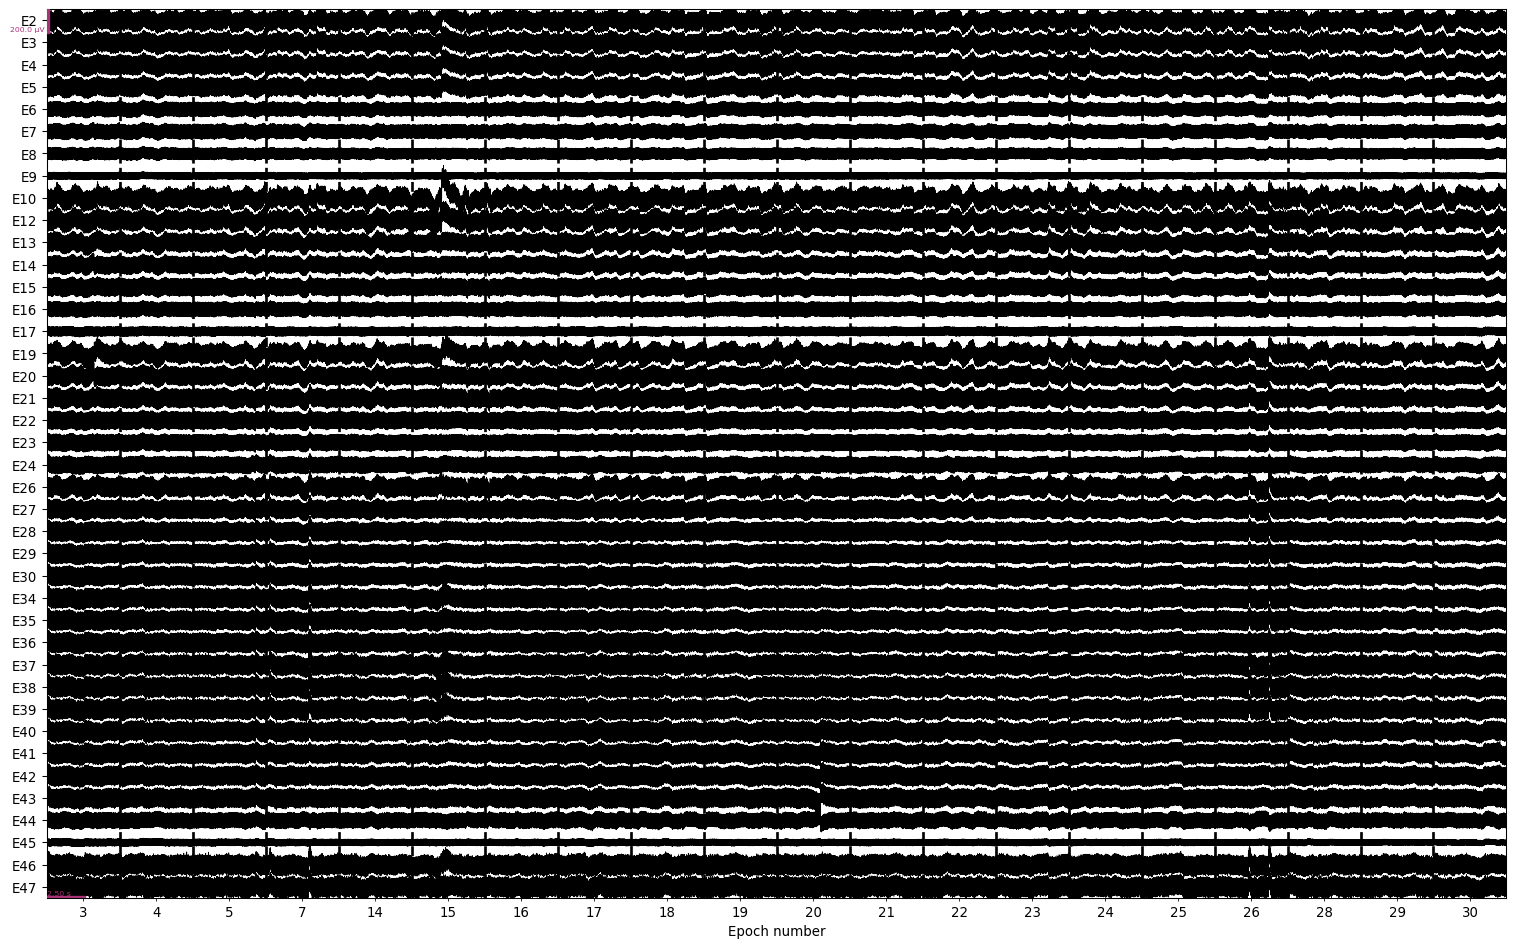

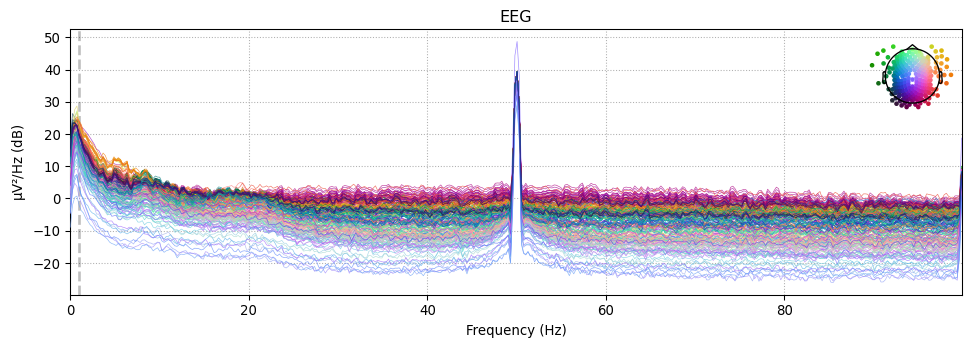

In [9]:
plot_epochs(
    epochs[~reject_log.bad_epochs],
    figures_path=figures_path,
    subject=subject,
    stage="autoreject_good_epochs",
    n_epochs=20,
    n_channels=40,
)

In [10]:
epochs[~reject_log.bad_epochs].save(
    f"{epochs_preproc_path}/sub-{subject}_drop_bad-epo.fif", overwrite=True
)

In [11]:
print(f"Sub{subject} -  removed {sum(reject_log.bad_epochs)} epochs")
print(f"Sub{subject} -  retained {len(epochs[~reject_log.bad_epochs])} epochs")

print_date_time()

Sub151 -  removed 5 epochs
Sub151 -  retained 58 epochs
2024-03-29 13:25:44
